# Retrieving Pan-STARRS data for Campaign 16

In this tutorial we show how to derive photometry from Pan-STARRS for K2 targets in C16.

First, let's pick a target.  We'll want a relatively isolated target with a photometric amplitude large enough to measure from the ground.

In [1]:
from lightkurve import KeplerTargetPixelFile

In [2]:
tpf = KeplerTargetPixelFile.from_archive(211691793, campaign=16)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os, warnings
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm_notebook as tqdm
import astropy.units as u

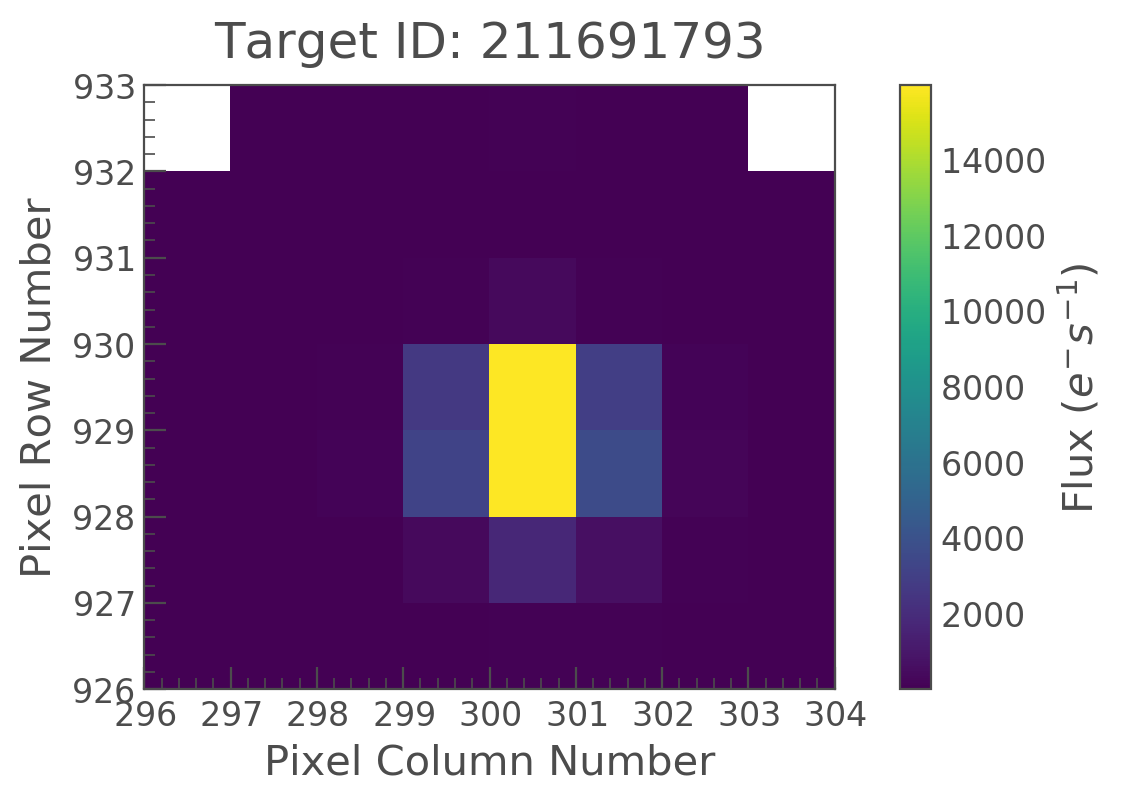

In [4]:
tpf.plot()

Looks decently isolated, and faint enough to be unsaturated in Pan-STARRS.

(3290, 3300)

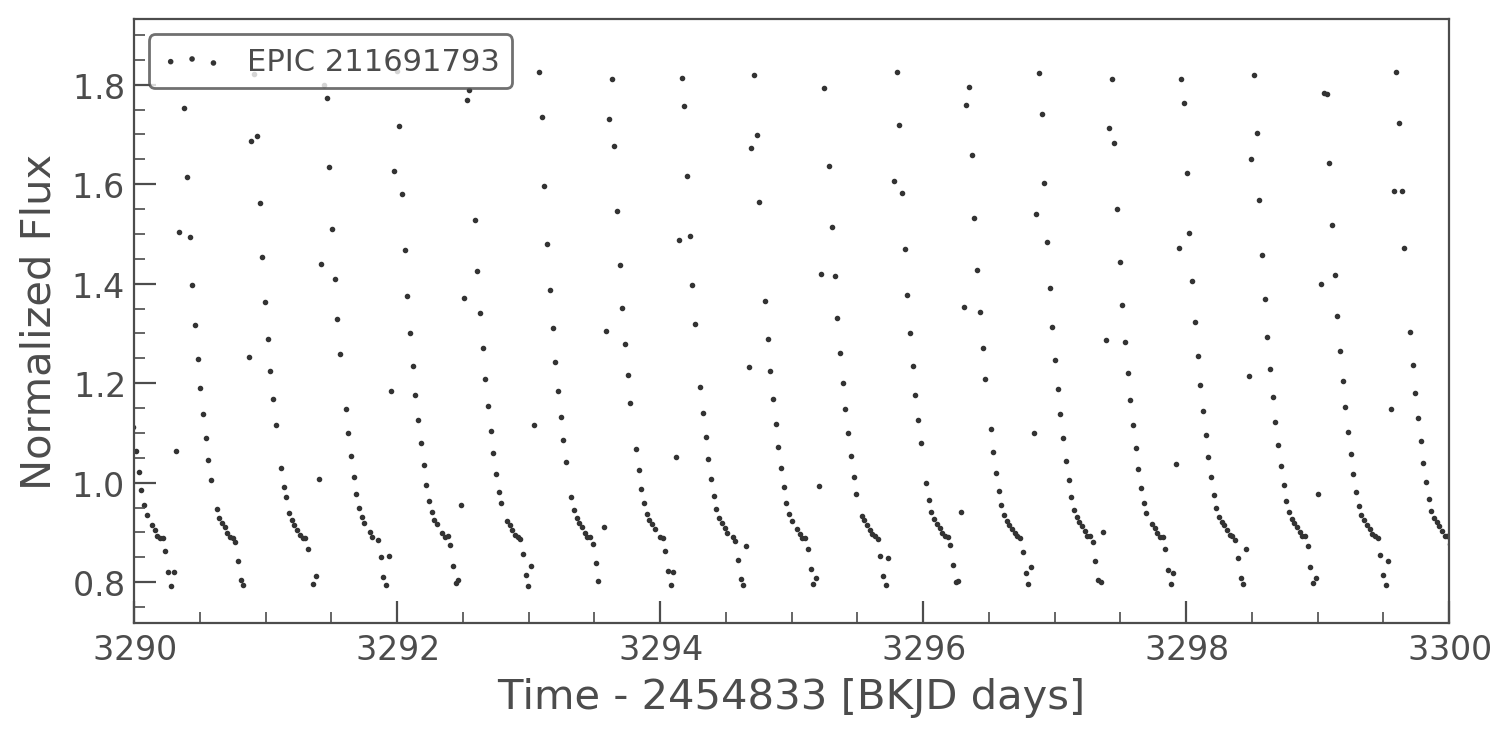

In [5]:
lc = tpf.to_lightcurve(aperture_mask='all')
lc.scatter()
plt.xlim(3290, 3300)

In [6]:
pg = lc.to_periodogram(period=np.arange(0.5, 0.6, 0.00001))

You have passed an evenly-spaced grid of periods. These are not evenly spaced in frequency space.
Method has been set to 'slow' to allow for this.


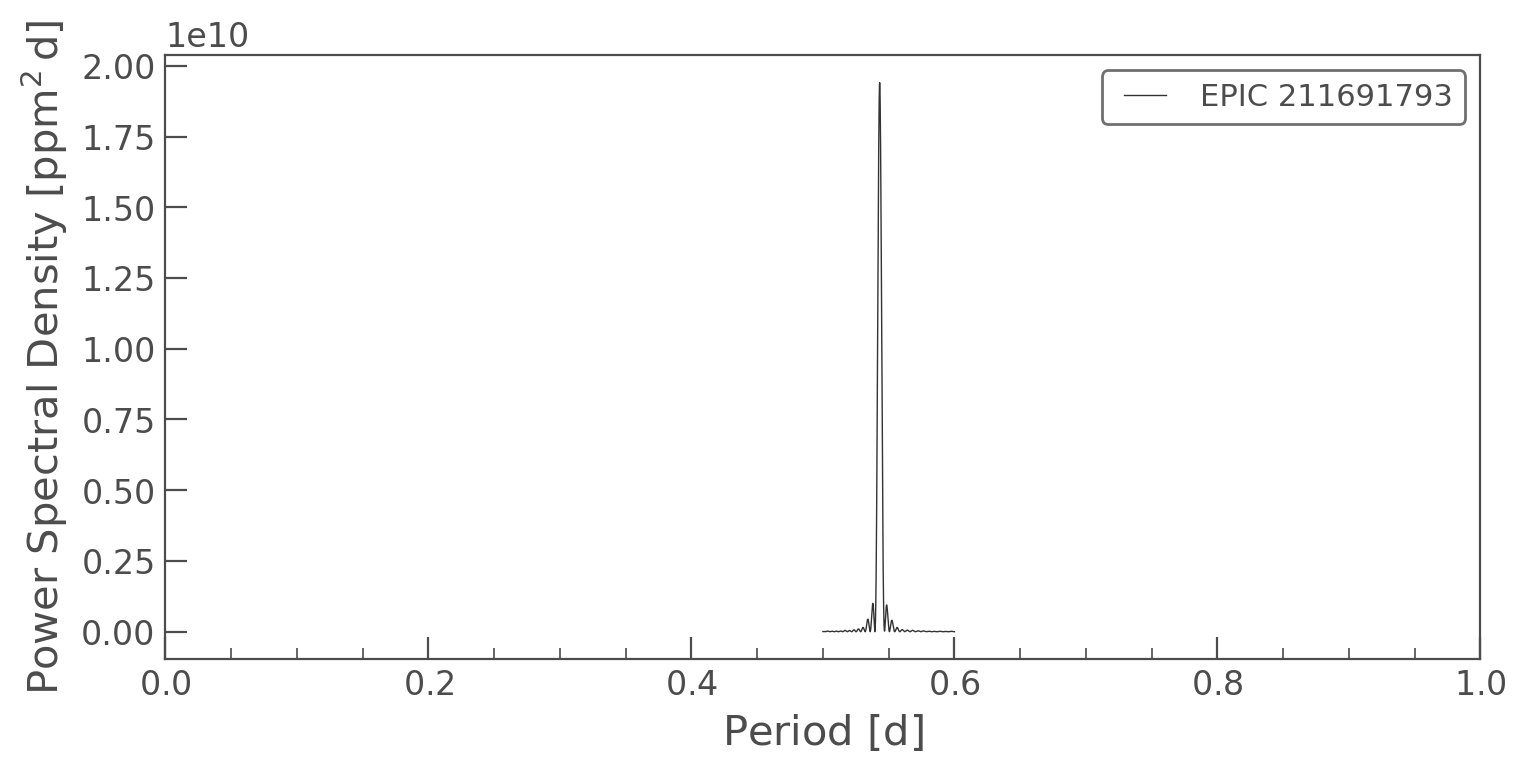

In [7]:
pg.plot(format='period')
plt.xlim(0, 1)
plt.yscale('linear')

It looks like the period hovers just short of 0.6 days.

In [8]:
pg.properties()

lightkurve.Periodogram properties:
      Attribute          Description    Units 
---------------------- ---------------- ------
              targetid        211691793       
                 label   EPIC 211691793       
frequency_at_max_power           1.8411  1 / d
             max_power 19404210302.0156 d ppm2
               nyquist          24.4672  1 / d
   period_at_max_power           0.5432      d
             frequency   array (10000,)  1 / d
                period   array (10000,)      d
                 power   array (10000,) d ppm2
                  meta   <class 'dict'>       


In [9]:
p_var = pg.period_at_max_power
p_var

<Quantity 0.54316 d>

In [10]:
p_var.to(u.hour)

<Quantity 13.03584 h>

The star has a 13 hour period, with a huge amplitude.  Let's phase fold the star on this period.

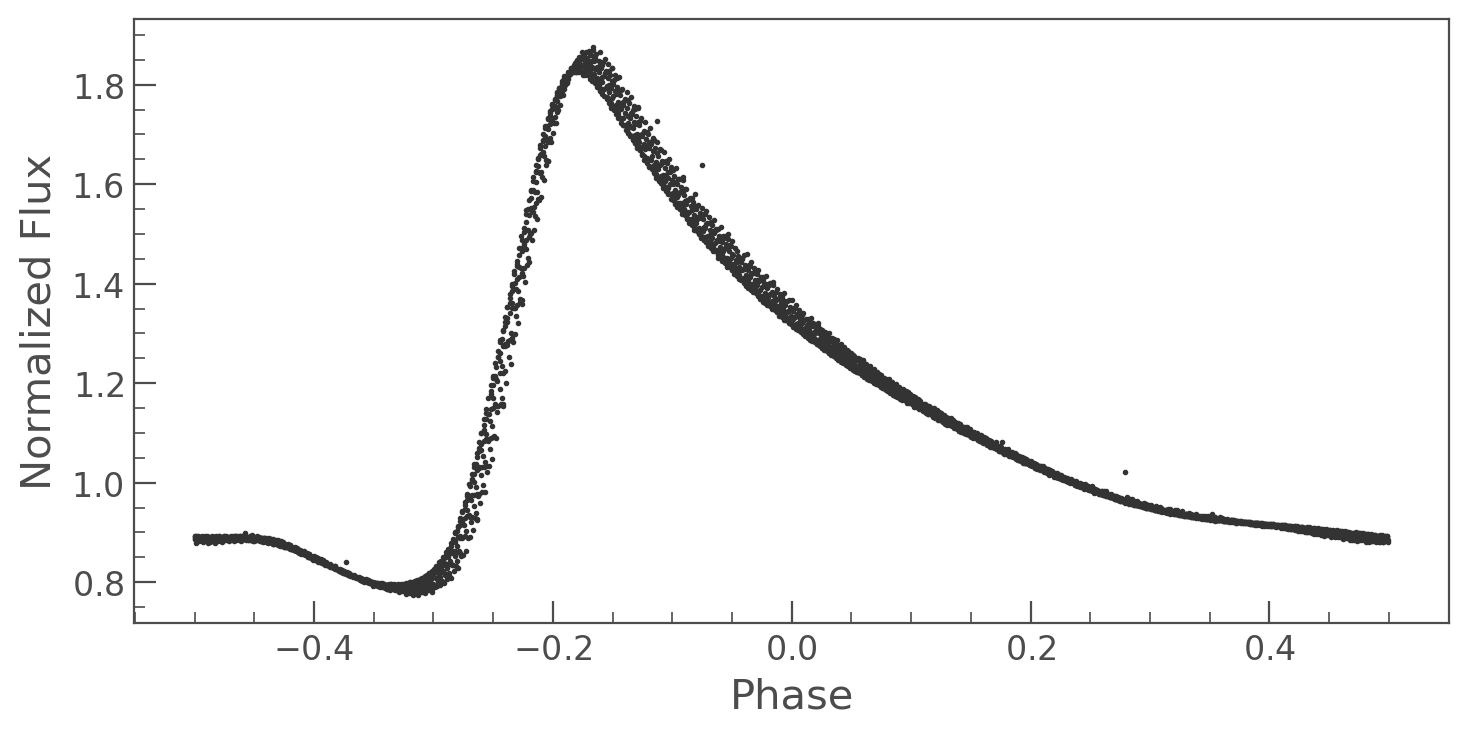

In [11]:
lc.fold(p_var.value).scatter()

Nice!  Let's see if we can get the contemporaneous Pan-STARRS data for this source.  We will follow the instructions from [the MAST-provided K2SNE demo](https://github.com/spacetelescope/MAST-API-Notebooks/blob/master/HLSP/K2SNE/k2sne_stack.ipynb).

In [12]:
def getimages(ra,dec,size=240,filters="griz",auxiliary="data,mask"):
    
    """Query hlspfilenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/hlspfilenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&auxiliary={auxiliary}&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table

In [13]:
ra0 = tpf.ra
dec0 = tpf.dec
table = getimages(ra0,dec0,size=800)
print('Found', len(table), 'images')

Found 126 images


In [14]:
def stackimages(imagelist, masklist):
    """Read FITS images from URLs and stack them
    
    imagelist is list of rows (from getimages) for the data
    masklist is corresponding list of rows for the stacks
    Returns stacked image, count of exposures in stack
    """
    n = len(imagelist)
    # assume all images are the same size
    im0 = fits.open(imagelist[0])[0].data
    mask0 = fits.open(masklist[0])[0].data
    # mask ought to be int but is float for some reason
    mask0[np.isnan(mask0)] = 0
    mask0 = mask0.astype(np.int32)
    imstack = np.zeros((n,im0.shape[0],im0.shape[1]), dtype=im0.dtype)
    imstack[0] = im0
    maskstack = np.zeros((n,im0.shape[0],im0.shape[1]), dtype=mask0.dtype)
    maskstack[0] = mask0
    for i in range(1,n):
        imstack[i] = fits.open(imagelist[i])[0].data
        mask0 = fits.open(masklist[i])[0].data
        mask0[np.isnan(mask0)] = 0
        maskstack[i] = mask0.astype(np.int32)
    # ignore all non-zero mask values in stack (conservative)
    imstack[maskstack != 0] = np.nan
    # suppress the annoying nanmean warning where all pixels are blank
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        im = np.nanmean(imstack,axis=0)
    count = np.isfinite(imstack).sum(axis=0)
    return im, count

In [15]:
imagelist = list(table['url'][(table['filter'] == 'g') & (table['type'] == 'warp')])
masklist = list(table['url'][(table['filter'] == 'g') & (table['type'] == 'warp.mask')])
im, count = stackimages(imagelist, masklist)

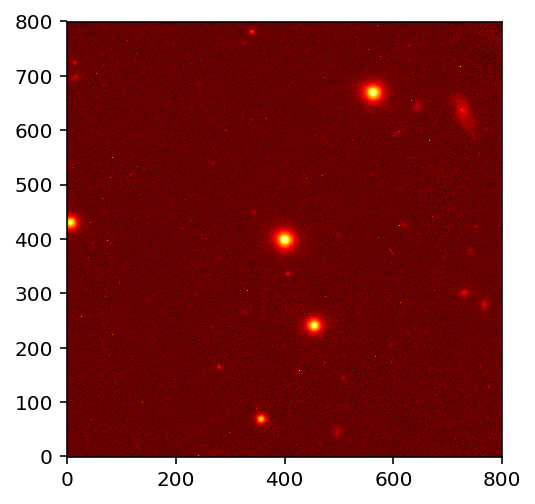

In [17]:
plt.imshow(np.arcsinh(im/10), cmap='hot', origin='lower')

In [20]:
table = table[table['type'] == 'warp']

Let's simplify the table to the essentials.

In [21]:
from astropy.stats import sigma_clipped_stats
from photutils import datasets
from photutils import DAOStarFinder

import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

In [22]:
def get_all_phot(dat_array, show_im=False):
    '''get aperture photometry given a 2D array with one star in it.'''
    mean, median, std = sigma_clipped_stats(dat_array, sigma=3.0, iters=5)    
    #print((mean, median, std))    
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)    
    sources = daofind(dat_array - median)    
    for col in sources.colnames:    
        sources[col].info.format = '%.8g'  # for consistent table output
    #print(sources)    
    
    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    if show_im:
        plt.imshow(dat_array, cmap='Greys', origin='lower', norm=norm)
        apertures.plot(color='blue', lw=1.5, alpha=0.5)
    
    return sources

In [23]:
all_sources = get_all_phot(im)

In [24]:
all_sources.sort('flux')
top5 = all_sources[::-1][0:5]

In [25]:
df = table.to_pandas()
df = df[['filter', 'mjd', 'type','url']]

Hopefully some of the data gets cached automatically, otherwise this step takes a few minutes.

In [26]:
def get_flux_from_source(source_table, xc=125, yc=125):
    '''returns the flux of the target star given a source table'''
    #find the right source
    rr = np.sqrt((source_table['xcentroid']-xc)**2 + 
                 (source_table['ycentroid']-yc)**2)
    ii = np.argmin(rr)
    if (rr[ii] < 3.0):
        flux = source_table['flux'][ii]
    else:
        flux = 0
    return flux

In [27]:
top5

<Table length=5>
  id  xcentroid ycentroid sharpness  ...   sky      peak      flux      mag    
int64  float64   float64   float64   ... float64  float64   float64   float64  
----- --------- --------- ---------- ... ------- --------- --------- ----------
   29 399.99934 399.25361 0.42477707 ...       0 15677.406 698.60399 -7.1105777
   39 562.52035 669.83479 0.46508474 ...       0 15633.353 615.27036  -6.972665
   15 454.06672 241.56619 0.41806313 ...       0 7897.6196 409.76226 -6.5313299
   30 5.7017992  430.7946 0.41947153 ...       0  6020.666 298.82184 -6.1885308
    7 356.48004 69.574003 0.45125597 ...       0 1147.2649 57.617167 -4.4013798

In [28]:
comparison_srcs = [0,1,2,4]

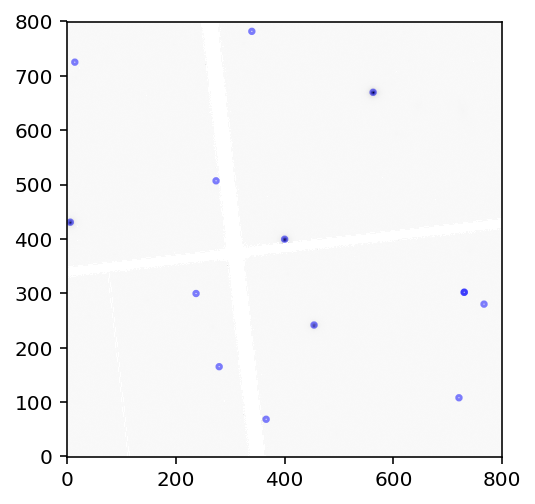

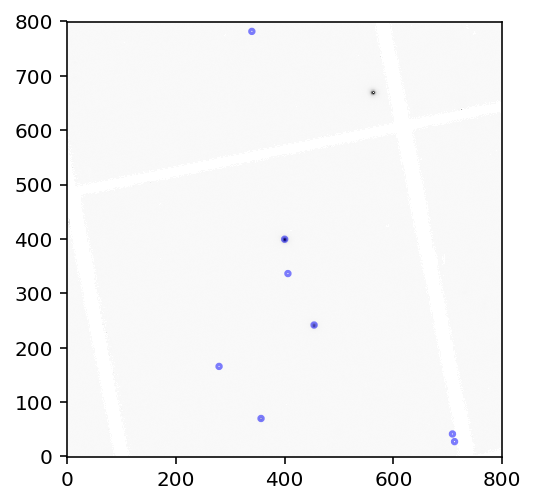

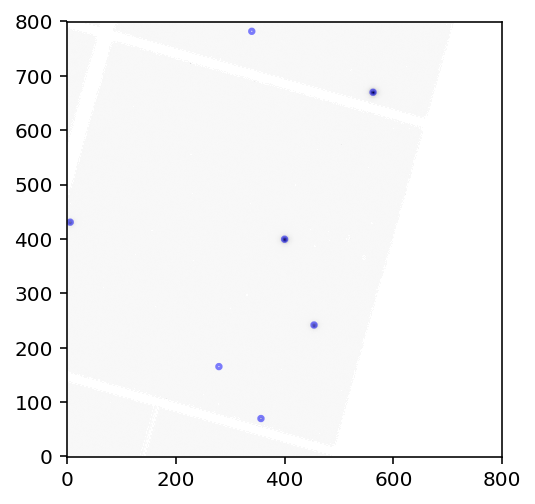

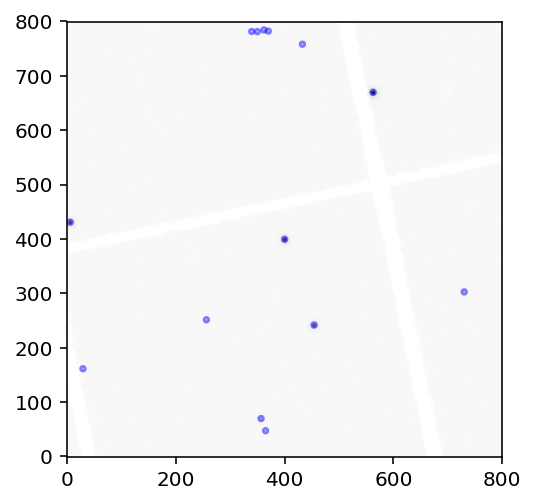

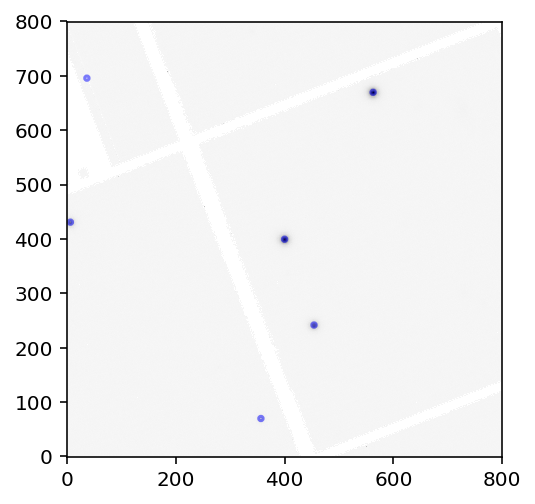

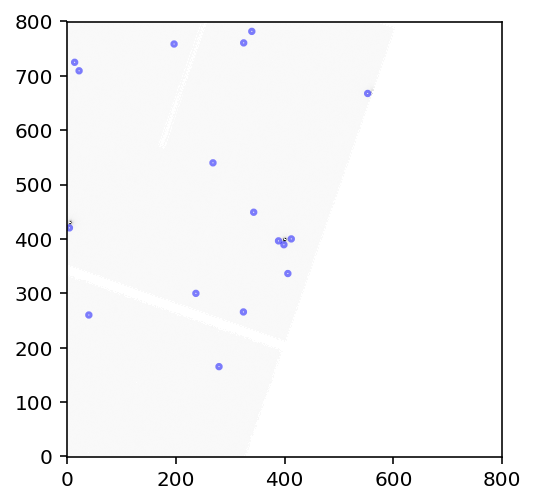

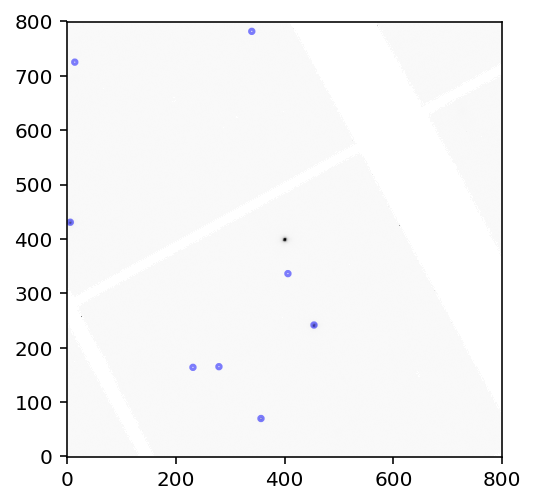

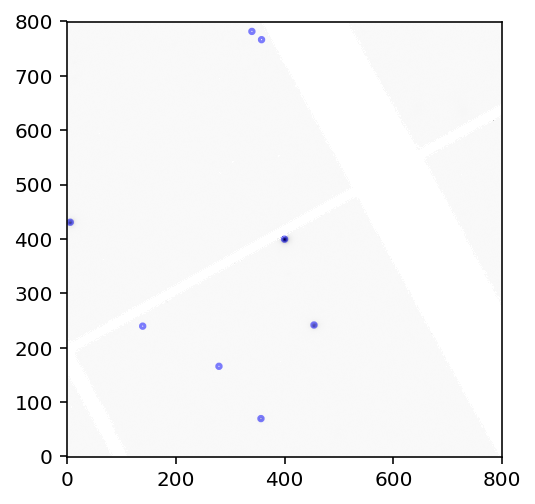

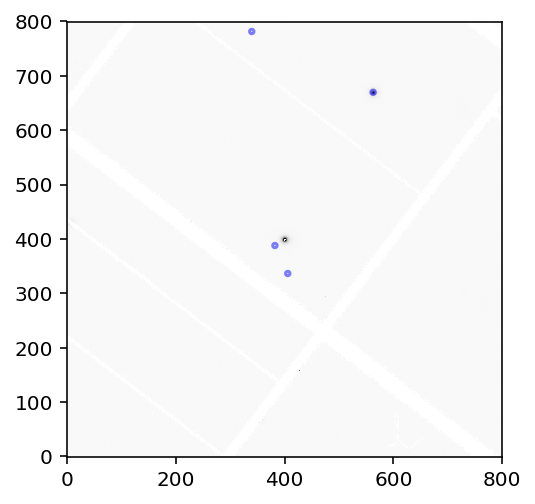

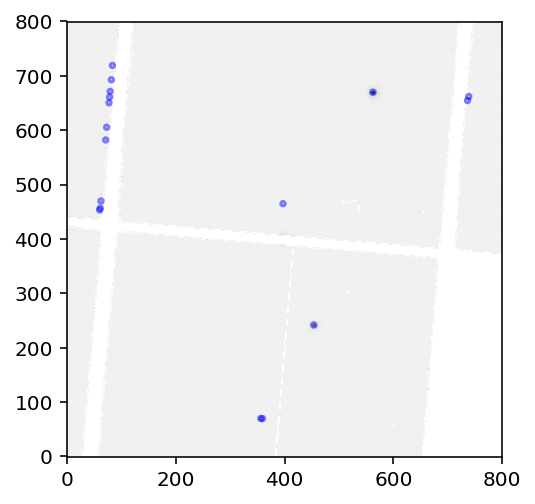

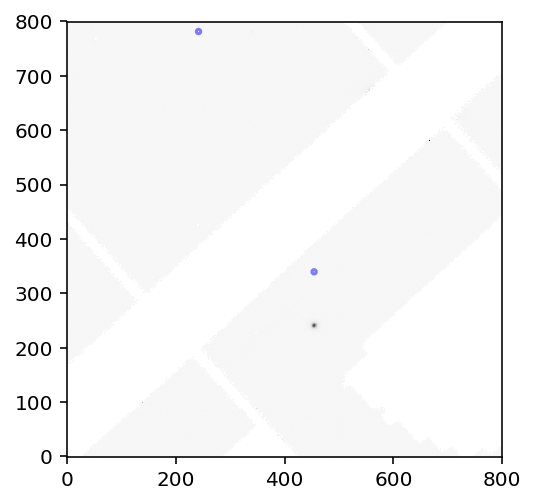

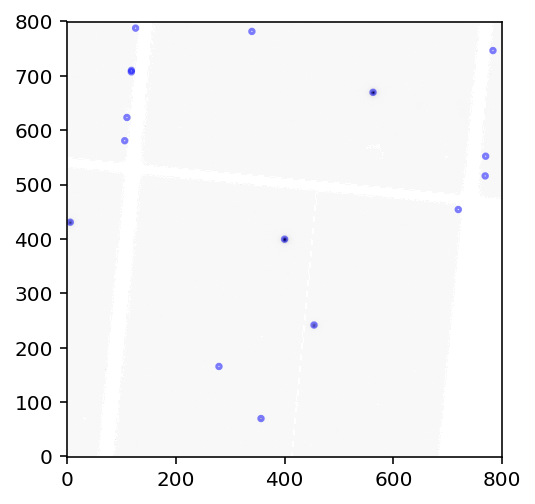

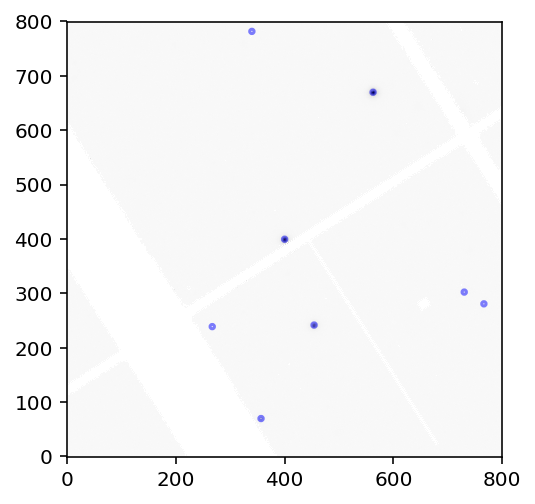

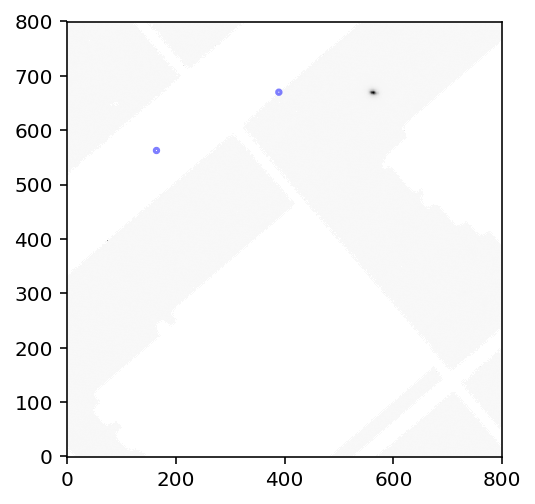

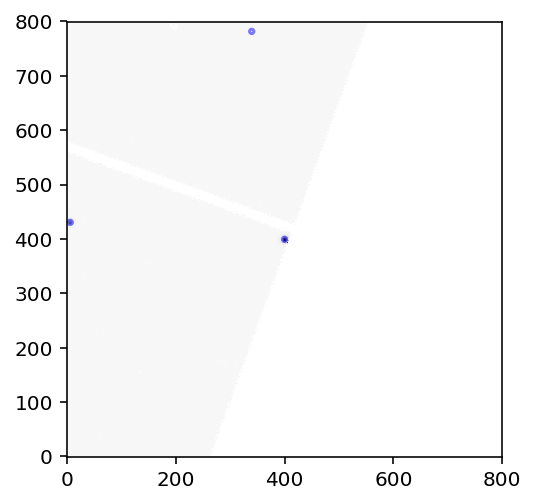

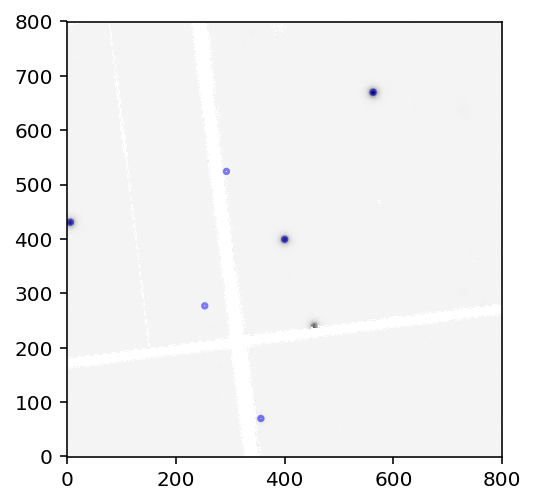

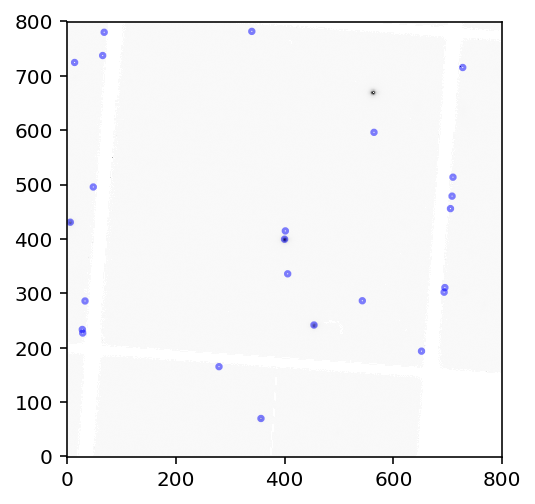

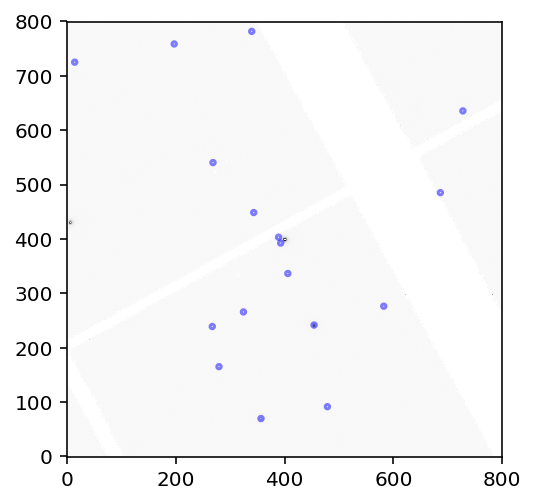

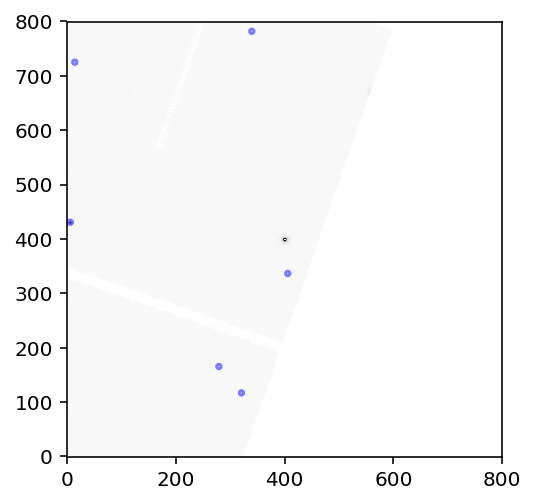

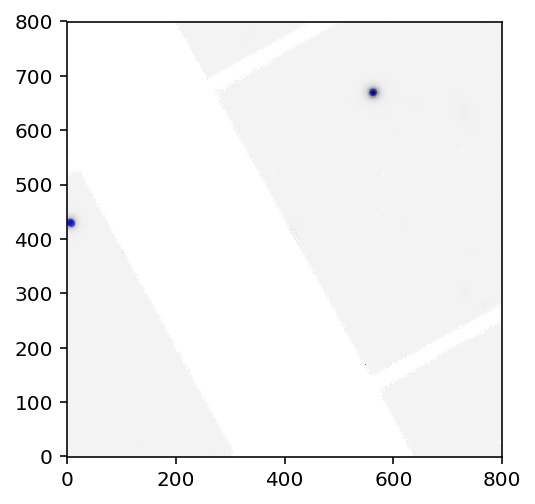

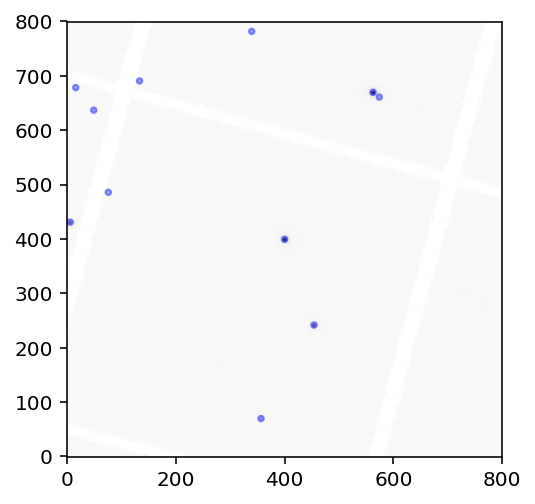

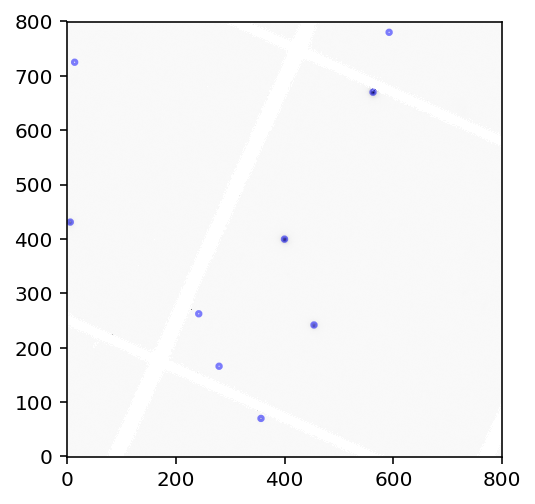

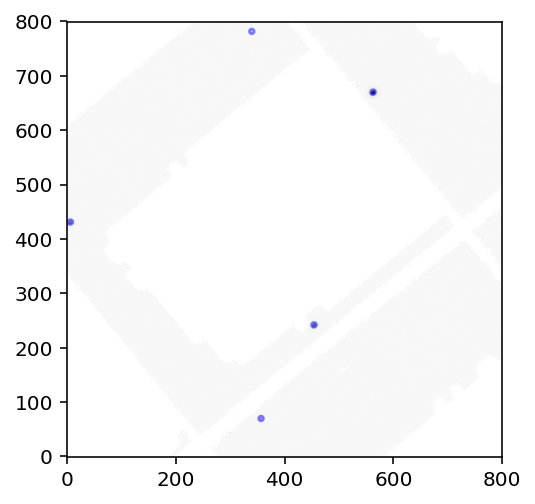

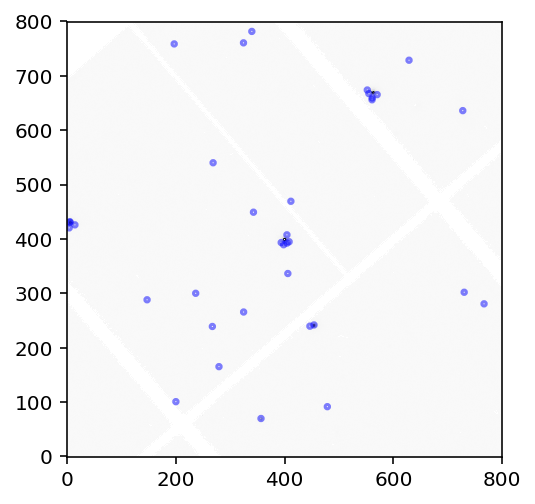

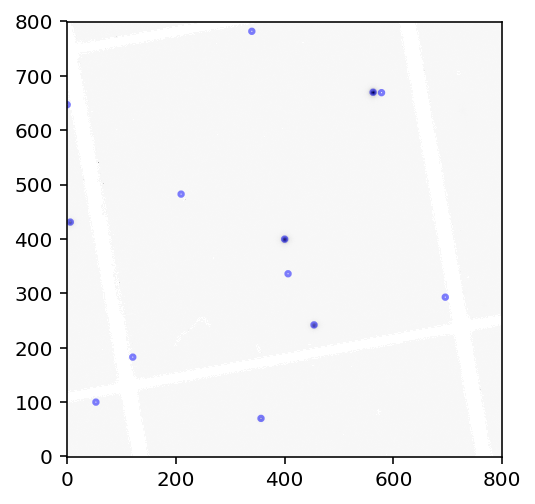

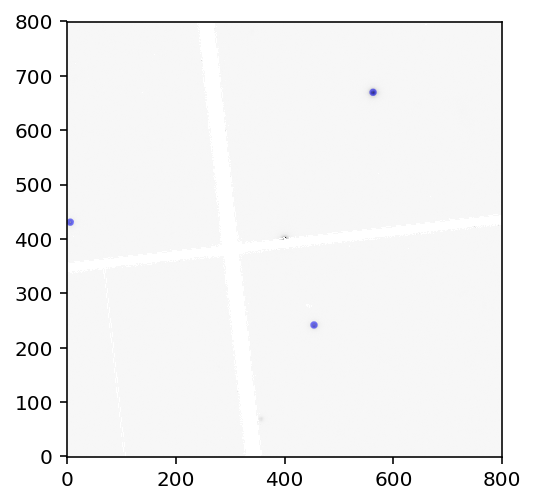

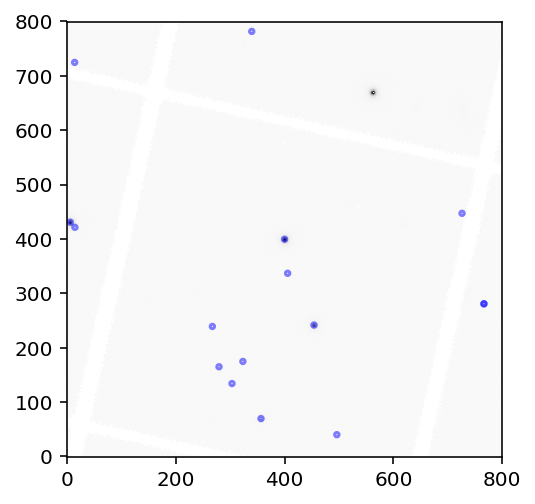

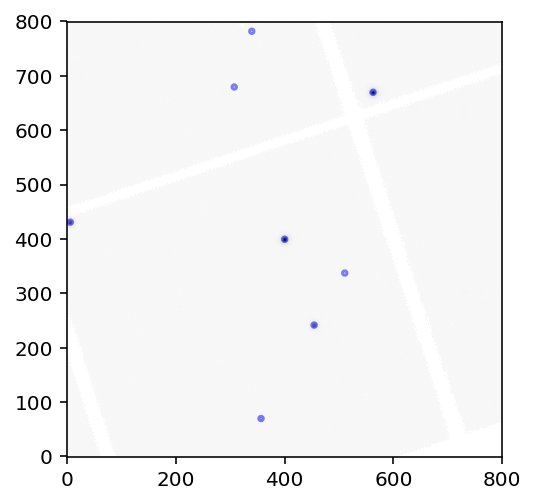

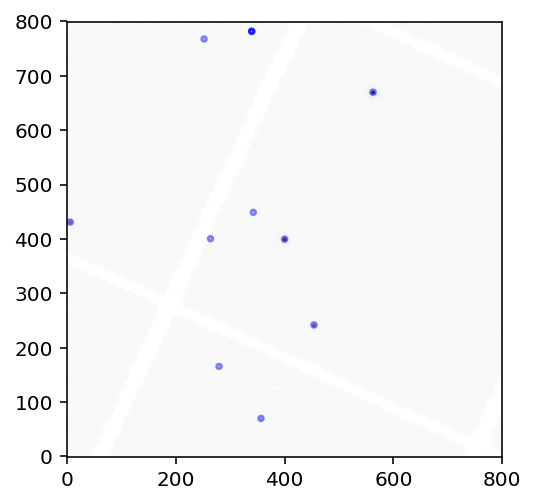

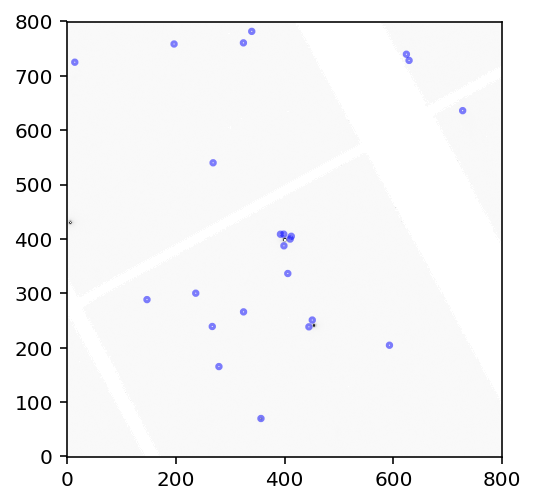

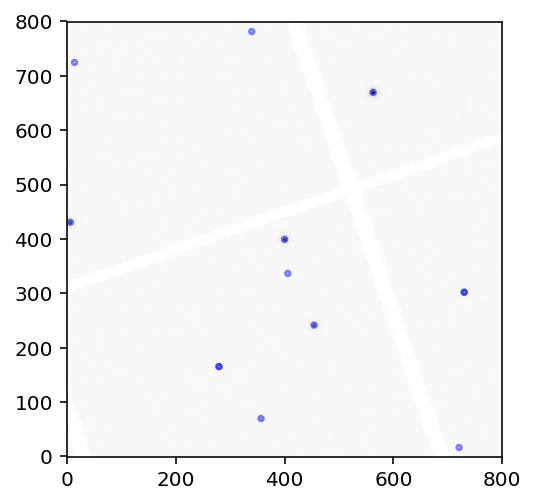

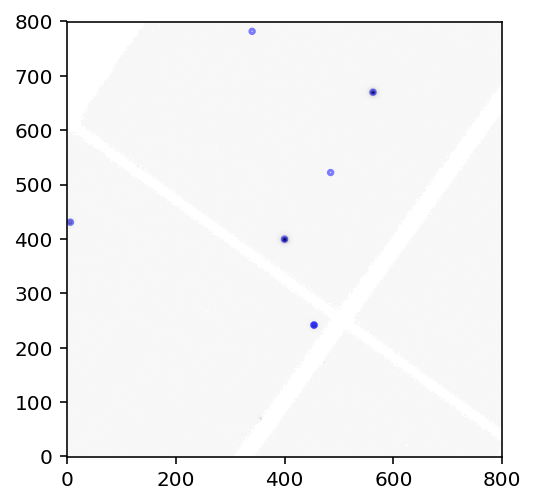

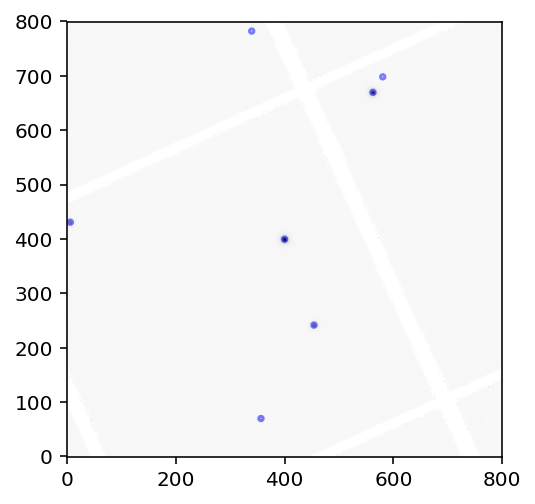

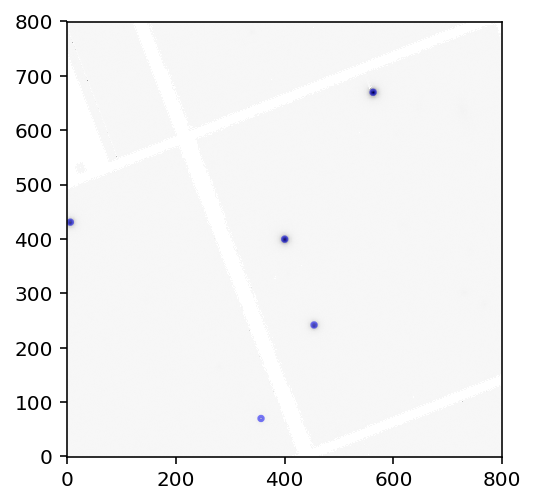

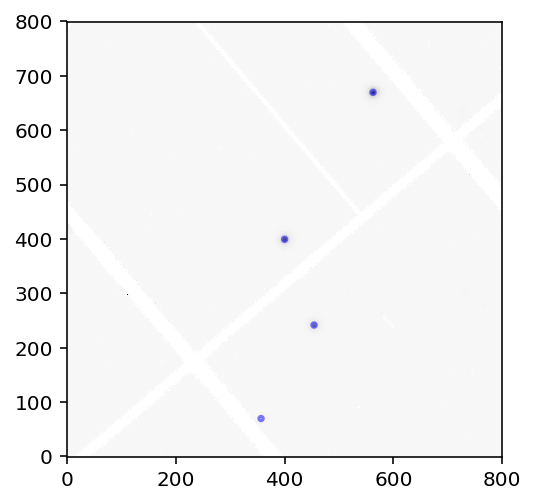

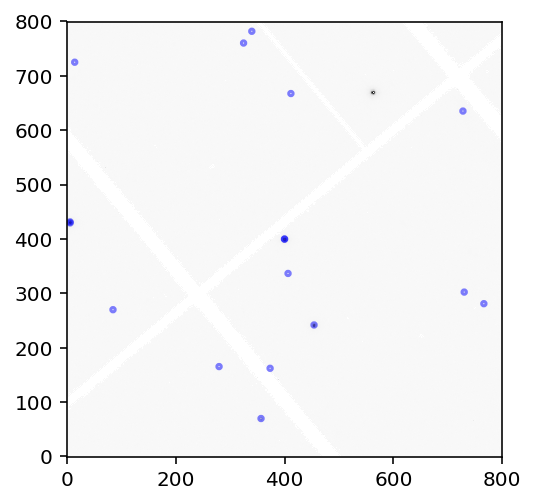

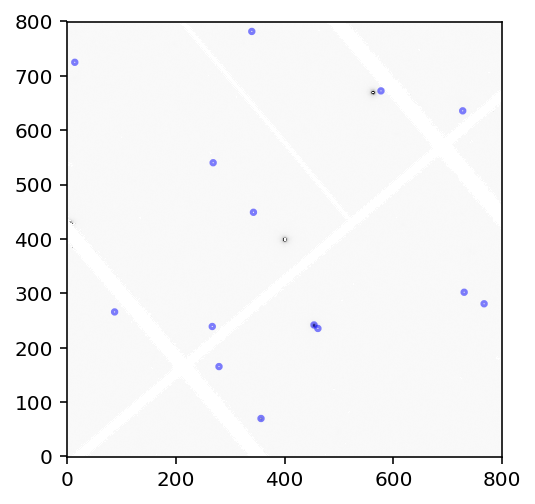

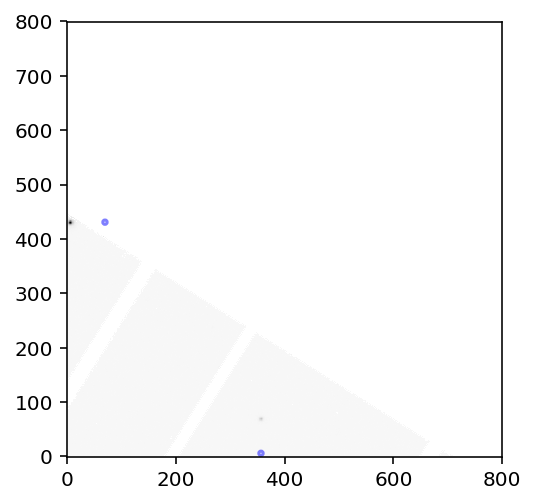

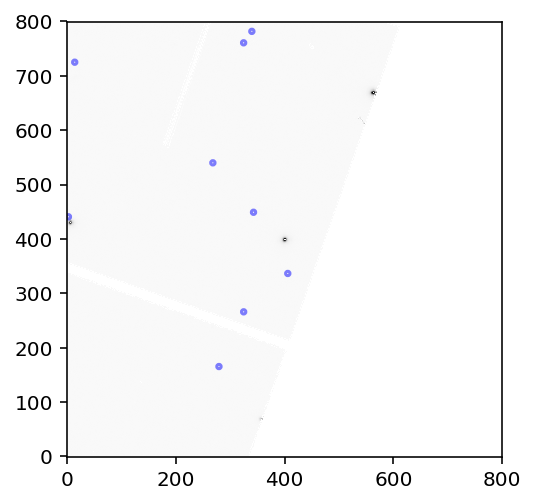

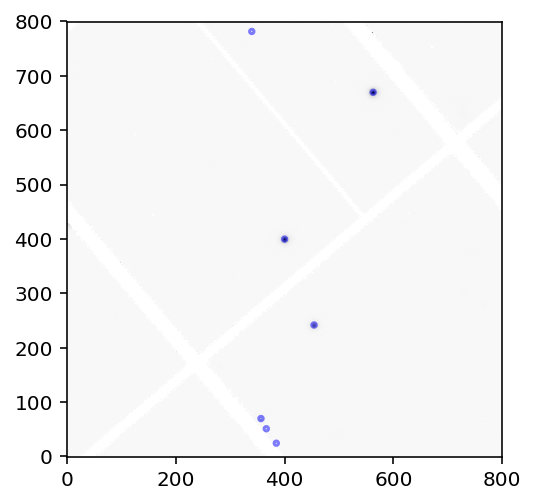

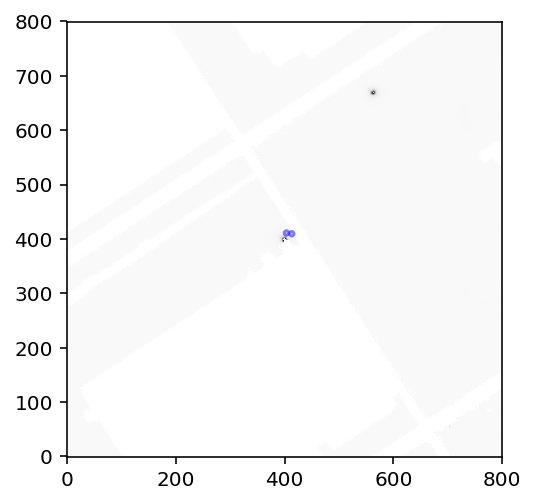

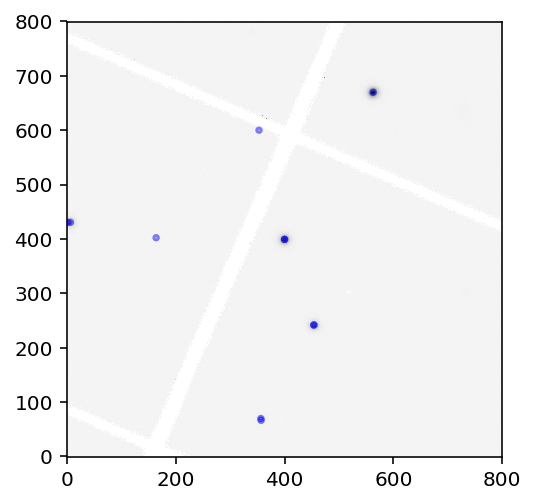

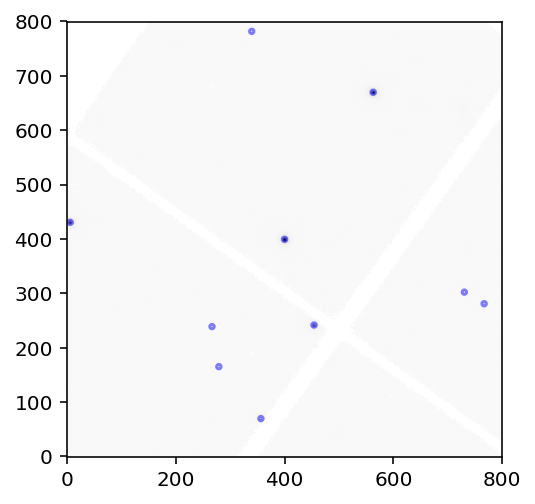

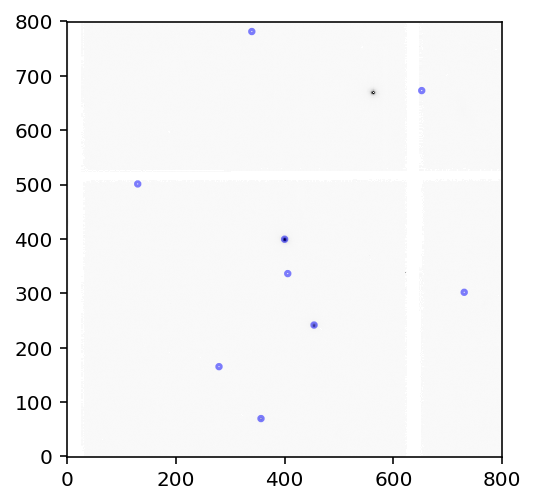

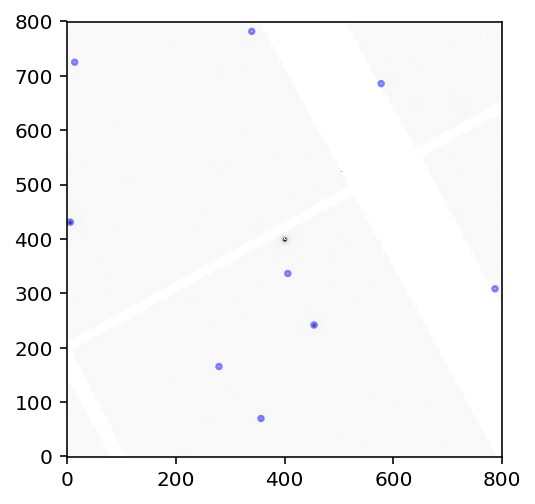

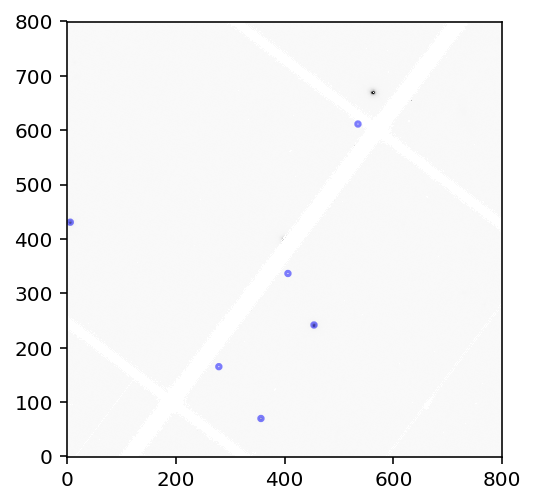

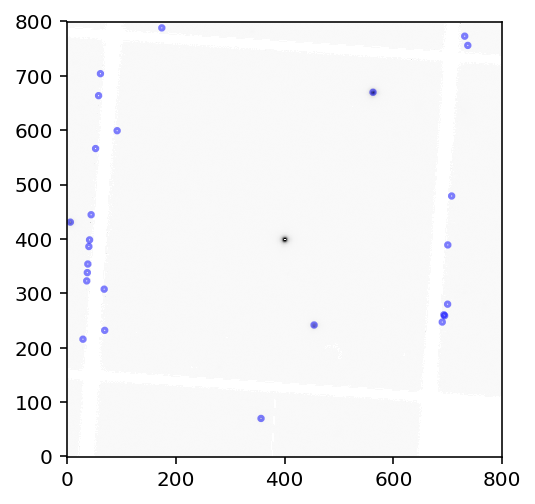

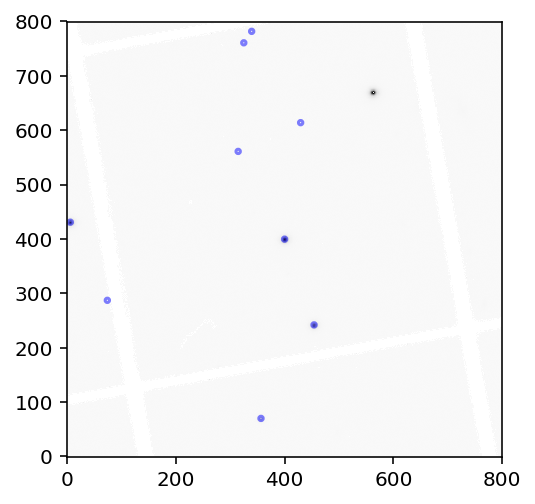

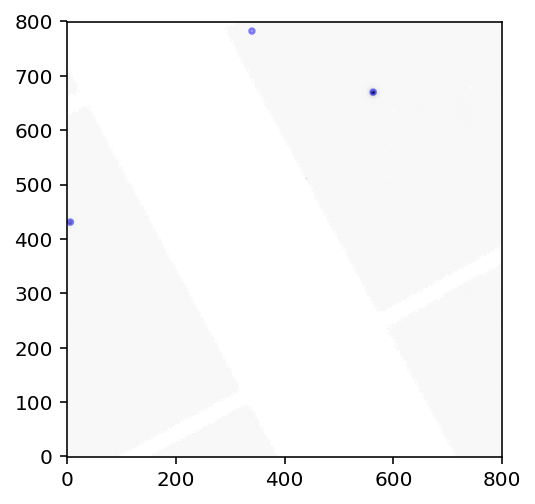

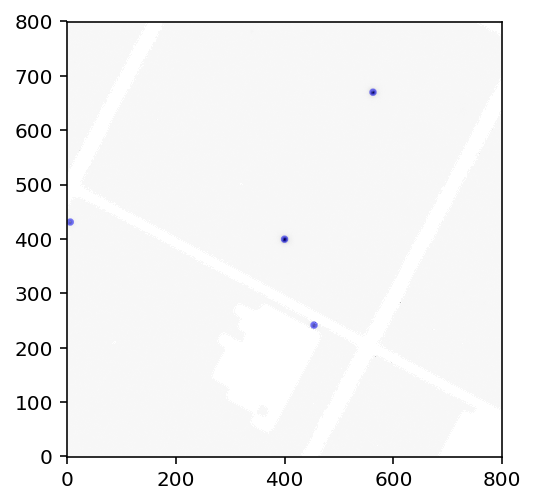

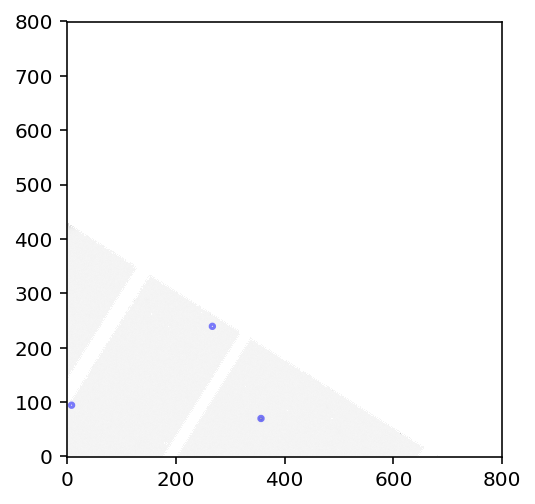

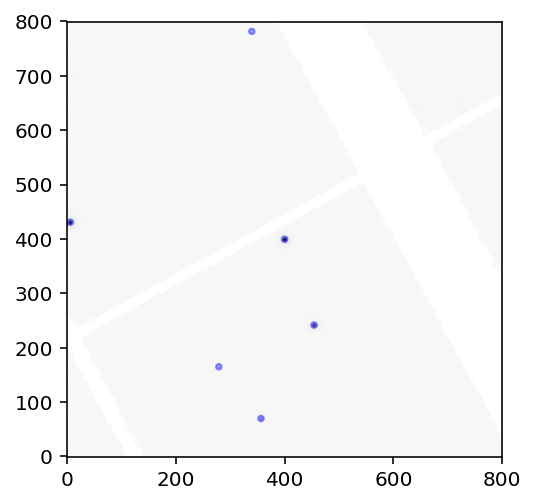

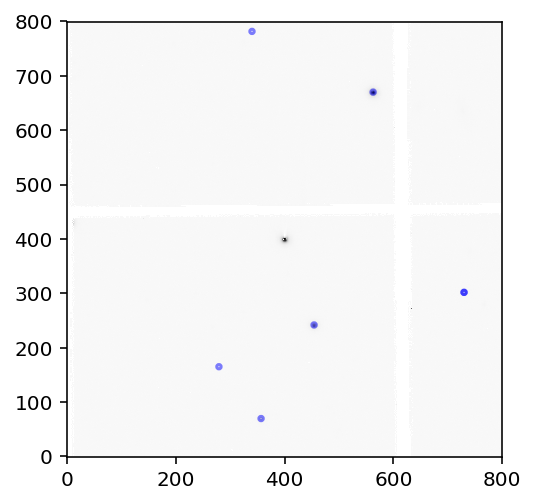

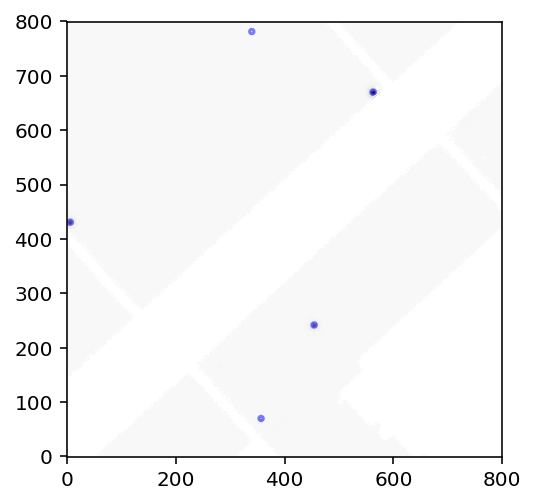

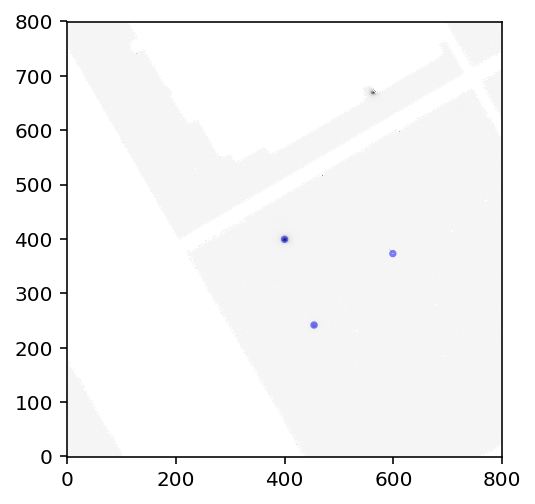

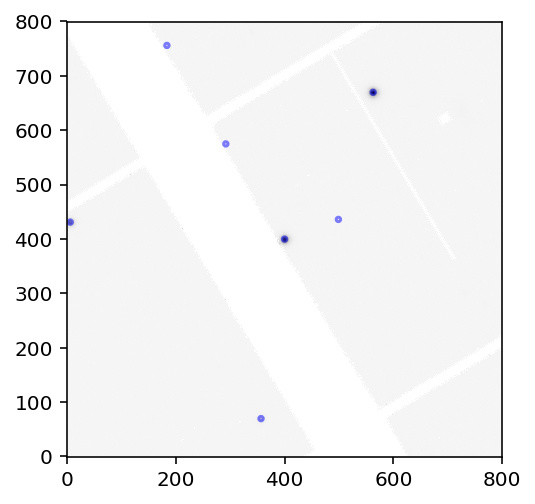

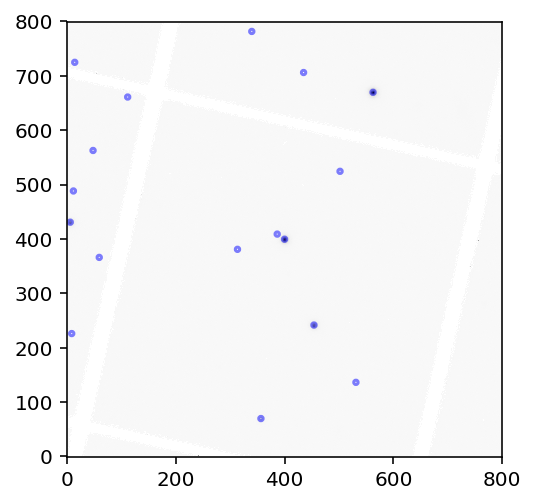

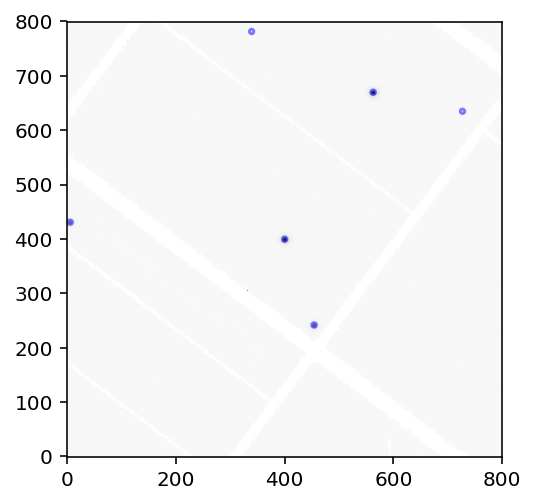

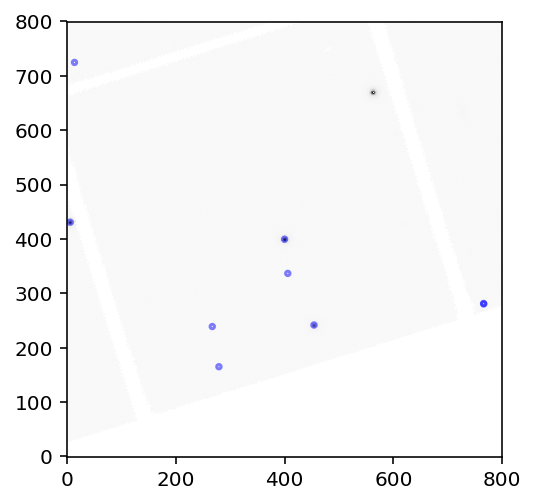

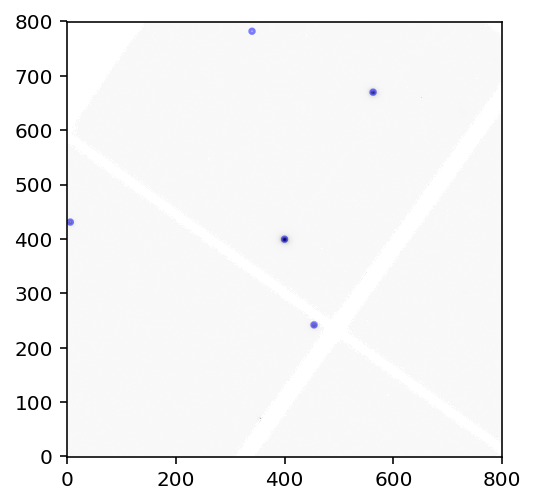

In [29]:
phot_vals = np.zeros((len(table), len(comparison_srcs)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in tqdm(range(len(table))):
        url = table['url'][i]
        hdu0 = fits.open(url)[0]
        try:
            srcs = get_all_phot(hdu0.data, show_im=True)
            plt.show()
            for jj, src in enumerate([0,1,2,4]):
                xx, yy = top5['xcentroid'][src], top5['ycentroid'][src]
                phot_vals[i, jj] = get_flux_from_source(srcs, xc=xx, yc=yy)
        except:
            pass

In [30]:
phot_vals.shape

(63, 4)

In [31]:
df['jd'] = df.mjd + 2400000.5

In [32]:
df = df.sort_values('jd')

In [33]:
df['raw_phot'] = np.array(phot_vals[:, 0])
df['star2'] = np.array(phot_vals[:, 1])
df['star3'] = np.array(phot_vals[:, 2])
df['star4'] = np.array(phot_vals[:, 3])

In [34]:
df_g = df[(df['filter'] == 'g') & (df.type == 'warp')]
df_i = df[(df['filter'] == 'i') & (df.type == 'warp')]

In [35]:
import seaborn as sns

In [36]:
sns.set_context('notebook')

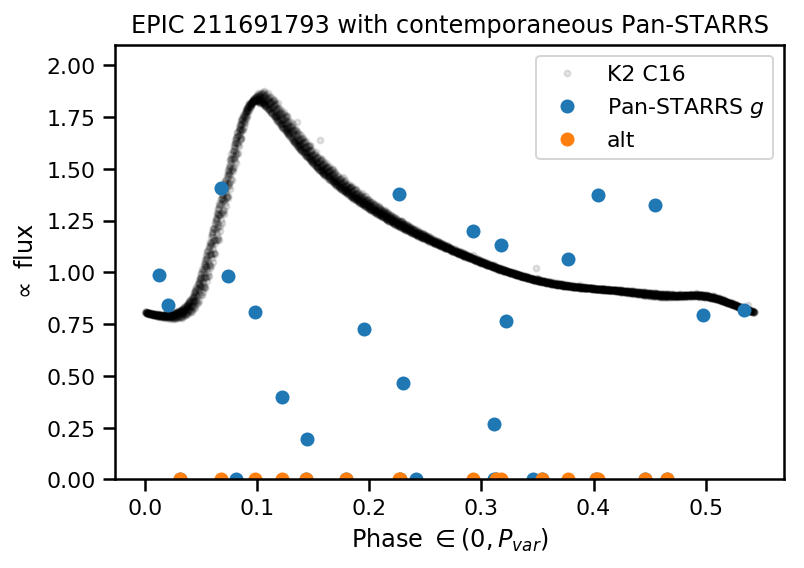

In [37]:
plt.plot((lc.time+2454833.0) % p_var.value, lc.normalize().flux, 'k.', alpha=0.1, label='K2 C16')
plt.plot((df_g.mjd.values+2400000.5) % p_var.value, df_g.raw_phot/250, 'o', label='Pan-STARRS $g$')
plt.plot((df_g.mjd.values+2400000.5) % p_var.value, df_g.star2, 'o', label='alt')
#plt.plot((df_i.mjd.values+2400000.5) % p_var.value, df_i.raw_phot/900000, 'o', label='Pan-STARRS $i$')
plt.legend()
plt.xlabel('Phase $\in (0, P_{var})$')
plt.ylim(0, 2.1)
plt.ylabel('$\propto$ flux');
plt.title('EPIC 211691793 with contemporaneous Pan-STARRS')
plt.savefig('K2_C16_Pan_STARRS_211691793.png', dpi=300, bbox_inches='tight')

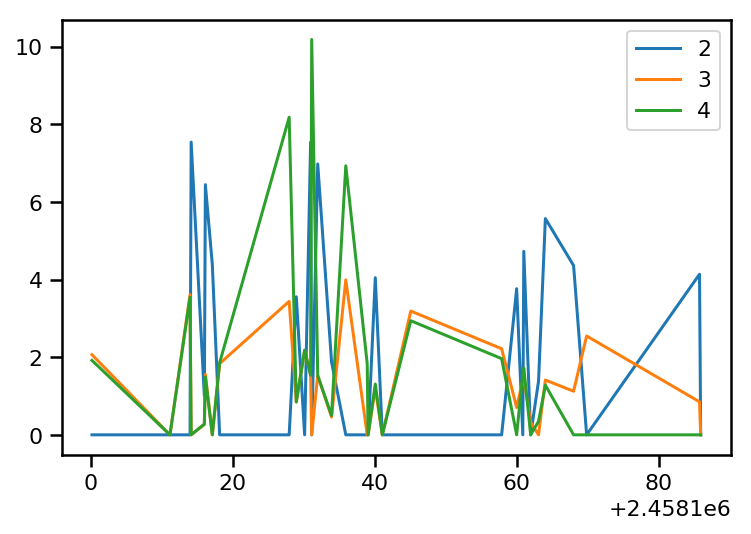

In [40]:
#plt.plot(df_g.mjd.values+2400000.5, df_g.raw_phot, 'o', label='2')
plt.plot(df_g.jd, df_g.star2/np.nanmedian(df.star2), '-', label='2')
plt.plot(df_g.jd, df_g.star3/np.nanmedian(df.star3), '-', label='3')
plt.plot(df_g.jd, df_g.star4/np.nanmedian(df.star4), '-', label='4')
plt.legend()

meh...